In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
 
!unzip "/content/drive/MyDrive/AML-Project/facesCrop.zip"
!unzip "/content/drive/MyDrive/AML-Project/portraitCrop.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/facecrop/facemoved55359.jpg  
  inflating: content/facecrop/facemoved64646.jpg  
  inflating: content/facecrop/facemoved16398.jpg  
  inflating: content/facecrop/facemoved97023.jpg  
  inflating: content/facecrop/facemoved65298.jpg  
  inflating: content/facecrop/facemoved81203.jpg  
  inflating: content/facecrop/facemoved15439.jpg  
  inflating: content/facecrop/facemoved67570.jpg  
  inflating: content/facecrop/facemoved37424.jpg  
  inflating: content/facecrop/facemoved59931.jpg  
  inflating: content/facecrop/facemoved46485.jpg  
  inflating: content/facecrop/facemoved23767.jpg  
  inflating: content/facecrop/facemoved71114.jpg  
  inflating: content/facecrop/facemoved31015.jpg  
  inflating: content/facecrop/facemoved75029.jpg  
  inflating: content/facecrop/facemoved50301.jpg  
  inflating: content/facecrop/facemoved76094.jpg  
  inflating: content/facecrop/facemoved12849.jpg  
  inflating: content/facecrop/f

In [2]:
import random, os, time
from PIL import Image

INPATH = r"content/famFaces/"
OUTPATH = r"content/facecrop/"

dx = dy = 256
tilesPerImage = 1
# Random Crop
files = os.listdir(INPATH)
numOfImages = len(files)
print(files)
t = time.time()
for file in files:
  with Image.open(os.path.join(INPATH,file)) as im:
    for i in range(1, tilesPerImage+1):
      print(im.size)
      im.save(OUTPATH +"facemoved" + file)


t = time.time()-t
print("Done {} images in {:.2f}s".format(numOfImages, t))
print("({:.1f} images per second)".format(numOfImages/t))
print("({:.1f} tiles per second)".format(tilesPerImage*numOfImages/t))

['1176585561_fd6743e60e_1345_19283506@N00.jpg', '1662001270_30c49e8743_2304_77446490@N00.jpg', '2116366211_6122d07339_2238_68046438@N00.jpg', '1272740422_f8c6077997_1245_65605251@N00.jpg', '1364175481_ebec946d86_1269_9147790@N08.jpg', '1316710706_6916868a57_1434_17093421@N00.jpg', '1426370543_33b0813b9e_1169_71242171@N00.jpg', '1676032127_db20ce71f5_2410_39437954@N00.jpg', '1881265586_1df8868953_2098_28941892@N00.jpg', '2024943162_195cf64ed8_2100_67035509@N00.jpg', '2098313418_7e31fc225b_2199_45438431@N00.jpg', '1618575601_17717d1210_2081_25559937@N00.jpg', '1992484506_b4f4114fd6_2275_68967634@N00.jpg', '1045766465_e100c8ec34_1333_73954615@N00.jpg', '1223967409_1db33a2c59_1412_19503391@N00.jpg', '2059629651_c123375447_2167_61935966@N00.jpg', '1721066219_23c8f532c3_2055_54688197@N00.jpg', '1914900611_94fc9bb717_2110_8692813@N06.jpg', '1024436545_147e615323_1170_96603368@N00.jpg', '1849979074_8c27b75f3f_2331_10520218@N03.jpg', '2131875947_1107f0df36_2017_7278220@N03.jpg', '1819253713_d9a

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))


In [4]:
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random


class ImageData(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = "facemoved" + split[0]
            values = split[1:]

            label = []
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')
            # print(label)
            if label != [False, False, False, False, False, False, False]:
              if (i+1) < 2000:
                  self.test_dataset.append([filename, label])
              else:
                  self.train_dataset.append([filename, label])
        # print(len(self.train_dataset))
        # print(len(self.test_dataset))

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images

In [5]:
def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128, 
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    # transform.append(T.CenterCrop(crop_size))
    # transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    dataset = ImageData(image_dir, attr_path, selected_attrs, transform, mode)
    # if dataset == 'CelebA':
    #     dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
    # elif dataset == 'RaFD':
    #     dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

In [6]:
data_loader = get_loader("content/facecrop", "/content/drive/MyDrive/AML-Project/list_attr_portrait_faces.txt", ["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"])
print(len(data_loader)* 16)

Finished preprocessing the CelebA dataset...
5216


In [10]:
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime


class Solver(object):
    """Solver for training and testing StarGAN."""

    def __init__(self, celeba_loader, rafd_loader, config):
        """Initialize configurations."""

        # Data loader.
        self.celeba_loader = celeba_loader
        self.rafd_loader = rafd_loader

        # Model configurations.
        self.c_dim = config.c_dim
        self.c2_dim = config.c2_dim
        self.image_size = config.image_size
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.g_repeat_num = config.g_repeat_num
        self.d_repeat_num = config.d_repeat_num
        self.lambda_cls = config.lambda_cls
        self.lambda_rec = config.lambda_rec
        self.lambda_gp = config.lambda_gp

        # Training configurations.
        self.dataset = config.dataset
        self.batch_size = config.batch_size
        self.num_iters = config.num_iters
        self.num_iters_decay = config.num_iters_decay
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.n_critic = config.n_critic
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.resume_iters = config.resume_iters
        self.selected_attrs = config.selected_attrs

        # Test configurations.
        self.test_iters = config.test_iters

        # Miscellaneous.
        self.use_tensorboard = config.use_tensorboard
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Directories.
        self.log_dir = config.log_dir
        self.sample_dir = config.sample_dir
        self.model_save_dir = config.model_save_dir
        self.result_dir = config.result_dir

        # Step size.
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.model_save_step = config.model_save_step
        self.lr_update_step = config.lr_update_step

        # Build the model and tensorboard.
        self.build_model()
        if self.use_tensorboard:
            self.build_tensorboard()

    def build_model(self):
        """Create a generator and a discriminator."""
        # if self.dataset in ['CelebA', 'RaFD']:
        self.G = Generator(self.g_conv_dim, self.c_dim, self.g_repeat_num)
        self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim, self.d_repeat_num) 
        # elif self.dataset in ['Both']:
        #     self.G = Generator(self.g_conv_dim, self.c_dim+self.c2_dim+2, self.g_repeat_num)   # 2 for mask vector.
        #     self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim+self.c2_dim, self.d_repeat_num)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])
        self.print_network(self.G, 'G')
        self.print_network(self.D, 'D')
            
        self.G.to(self.device)
        self.D.to(self.device)

    def print_network(self, model, name):
        """Print out the network information."""
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print("The number of parameters: {}".format(num_params))

    def restore_model(self, resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    def build_tensorboard(self):
        """Build a tensorboard logger."""
        # from logger import Logger
        self.logger = Logger(self.log_dir)

    def update_lr(self, g_lr, d_lr):
        """Decay learning rates of the generator and discriminator."""
        for param_group in self.g_optimizer.param_groups:
            param_group['lr'] = g_lr
        for param_group in self.d_optimizer.param_groups:
            param_group['lr'] = d_lr

    def reset_grad(self):
        """Reset the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def denorm(self, x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

    def gradient_penalty(self, y, x):
        """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
        weight = torch.ones(y.size()).to(self.device)
        dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]

        dydx = dydx.view(dydx.size(0), -1)
        dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
        return torch.mean((dydx_l2norm-1)**2)

    def label2onehot(self, labels, dim):
        """Convert label indices to one-hot vectors."""
        batch_size = labels.size(0)
        out = torch.zeros(batch_size, dim)
        out[np.arange(batch_size), labels.long()] = 1
        return out

    def create_labels(self, c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get hair color indices.
        if dataset == 'CelebA':
            hair_color_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in selected_attrs:
                    hair_color_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'CelebA':
                c_trg = c_org.clone()
                if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in hair_color_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

            elif dataset == 'RaFD':
                c_trg = self.label2onehot(torch.ones(c_org.size(0))*i, c_dim)

            c_trg_list.append(c_trg.to(self.device))
        # print(c_trg_list)
        return c_trg_list

    def classification_loss(self, logit, target, dataset='CelebA'):
        """Compute binary or softmax cross entropy loss."""
        if dataset == 'CelebA':
            return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
        elif dataset == 'RaFD':
            return F.cross_entropy(logit, target)

    def train(self):
        """Train StarGAN within a single dataset."""
        # Set data loader.
        data_loader = self.celeba_loader

        # if self.dataset == 'CelebA':
            # data_loader = self.celeba_loader
        # elif self.dataset == 'RaFD':
            # data_loader = self.rafd_loader

        # Fetch fixed inputs for debugging.
        data_iter = iter(data_loader)
        x_fixed, c_org = next(data_iter)
        x_fixed1, c_org1 = next(data_iter)
        x_fixed2, c_org2 = next(data_iter)
        x_fixed3, c_org3 = next(data_iter)

        x_fixed = x_fixed.to(self.device)
        x_fixed1 = x_fixed1.to(self.device)
        x_fixed2 = x_fixed2.to(self.device)
        x_fixed3 = x_fixed3.to(self.device)

        print(c_org)
        print(c_org1)
        print(c_org2)
        print(c_org3)



        c_fixed_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)

        # Learning rate cache for decaying.
        g_lr = self.g_lr
        d_lr = self.d_lr

        # Start training from scratch or resume training.
        start_iters = 0
        if self.resume_iters:
            start_iters = self.resume_iters
            self.restore_model(self.resume_iters)

        # Start training.
        print('Start training...')
        start_time = time.time()
        for i in range(start_iters, self.num_iters):

            # =================================================================================== #
            #                             1. Preprocess input data                                #
            # =================================================================================== #

            # Fetch real images and labels.
            try:
                x_real, label_org = next(data_iter)
            except:
                data_iter = iter(data_loader)
                x_real, label_org = next(data_iter)

            # Generate target domain labels randomly.
            rand_idx = torch.randperm(label_org.size(0))
            label_trg = label_org[rand_idx]

            # if self.dataset == 'CelebA':
            c_org = label_org.clone()
            c_trg = label_trg.clone()
            # elif self.dataset == 'RaFD':
            #     c_org = self.label2onehot(label_org, self.c_dim)
            #     c_trg = self.label2onehot(label_trg, self.c_dim)

            x_real = x_real.to(self.device)           # Input images.
            c_org = c_org.to(self.device)             # Original domain labels.
            c_trg = c_trg.to(self.device)             # Target domain labels.
            label_org = label_org.to(self.device)     # Labels for computing classification loss.
            label_trg = label_trg.to(self.device)     # Labels for computing classification loss.

            # =================================================================================== #
            #                             2. Train the discriminator                              #
            # =================================================================================== #

            # Compute loss with real images.
            out_src, out_cls = self.D(x_real)
            d_loss_real = - torch.mean(out_src)
            d_loss_cls = self.classification_loss(out_cls, label_org, self.dataset)

            # Compute loss with fake images.
            x_fake = self.G(x_real, c_trg)
            out_src, out_cls = self.D(x_fake.detach())
            d_loss_fake = torch.mean(out_src)

            # Compute loss for gradient penalty.
            alpha = torch.rand(x_real.size(0), 1, 1, 1).to(self.device)
            x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            out_src, _ = self.D(x_hat)
            d_loss_gp = self.gradient_penalty(out_src, x_hat)

            # Backward and optimize.
            d_loss = d_loss_real + d_loss_fake + self.lambda_cls * d_loss_cls + self.lambda_gp * d_loss_gp
            self.reset_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Logging.
            loss = {}
            loss['D/loss_real'] = d_loss_real.item()
            loss['D/loss_fake'] = d_loss_fake.item()
            loss['D/loss_cls'] = d_loss_cls.item()
            loss['D/loss_gp'] = d_loss_gp.item()
            
            # =================================================================================== #
            #                               3. Train the generator                                #
            # =================================================================================== #
            
            if (i+1) % self.n_critic == 0:
                # Original-to-target domain.
                x_fake = self.G(x_real, c_trg)
                out_src, out_cls = self.D(x_fake)
                g_loss_fake = - torch.mean(out_src)
                g_loss_cls = self.classification_loss(out_cls, label_trg, self.dataset)

                # Target-to-original domain.
                x_reconst = self.G(x_fake, c_org)
                g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

                # Backward and optimize.
                g_loss = g_loss_fake + self.lambda_rec * g_loss_rec + self.lambda_cls * g_loss_cls
                self.reset_grad()
                g_loss.backward()
                self.g_optimizer.step()

                # Logging.
                loss['G/loss_fake'] = g_loss_fake.item()
                loss['G/loss_rec'] = g_loss_rec.item()
                loss['G/loss_cls'] = g_loss_cls.item()

            # =================================================================================== #
            #                                 4. Miscellaneous                                    #
            # =================================================================================== #

            # Print out training information.
            if (i+1) % self.log_step == 0:
                et = time.time() - start_time
                et = str(datetime.timedelta(seconds=et))[:-7]
                log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, self.num_iters)
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)

                if self.use_tensorboard:
                    for tag, value in loss.items():
                        self.logger.scalar_summary(tag, value, i+1)

            # Translate fixed images for debugging.
            if (i+1) % self.sample_step == 0:
                with torch.no_grad():
                    x_fake_list = [x_fixed]
                    for c_fixed in c_fixed_list:
                        x_fake_list.append(self.G(x_fixed, c_fixed))
                    iterSampleDir = self.sample_dir + "/"  + '{}-images'.format(i+1)
                    if not os.path.exists(iterSampleDir):
                        os.makedirs(iterSampleDir)
                    for index, im in enumerate(x_fake_list):
                      if not os.path.exists(iterSampleDir + "/" +str(index)):
                        os.makedirs(iterSampleDir + "/" + str(index))
                      for dex, oneimage in enumerate(im):
                        result_path = os.path.join(iterSampleDir + '/' + str(index) + '/' + str(dex) +'-image.jpg')
                        save_image(self.denorm(oneimage), result_path, nrow=1, padding=0)

                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)

                    x_fake_list = [x_fixed1]
                    for c_fixed in c_fixed_list:
                        x_fake_list.append(self.G(x_fixed1, c_fixed))
                    iterSampleDir = self.sample_dir + "/"  + '{}-images'.format(i+1)
                    if not os.path.exists(iterSampleDir):
                        os.makedirs(iterSampleDir)
                    for index, im in enumerate(x_fake_list):
                      if not os.path.exists(iterSampleDir + "/" +str(index)):
                        os.makedirs(iterSampleDir + "/" + str(index))
                      for dex, oneimage in enumerate(im):
                        result_path = os.path.join(iterSampleDir + '/' + str(index) + '/' + str(dex + 12) +'-image.jpg')
                        save_image(self.denorm(oneimage), result_path, nrow=1, padding=0)

                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images2.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)

                    x_fake_list = [x_fixed2]
                    for c_fixed in c_fixed_list:
                        x_fake_list.append(self.G(x_fixed2, c_fixed))
                    iterSampleDir = self.sample_dir + "/"  + '{}-images'.format(i+1)
                    if not os.path.exists(iterSampleDir):
                        os.makedirs(iterSampleDir)
                    for index, im in enumerate(x_fake_list):
                      if not os.path.exists(iterSampleDir + "/" +str(index)):
                        os.makedirs(iterSampleDir + "/" + str(index))
                      for dex, oneimage in enumerate(im):
                        result_path = os.path.join(iterSampleDir + '/' + str(index) + '/' + str(dex + 24) +'-image.jpg')
                        save_image(self.denorm(oneimage), result_path, nrow=1, padding=0)

                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images3.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)

                    x_fake_list = [x_fixed3]
                    for c_fixed in c_fixed_list:
                        x_fake_list.append(self.G(x_fixed3, c_fixed))
                    iterSampleDir = self.sample_dir + "/"  + '{}-images'.format(i+1)
                    if not os.path.exists(iterSampleDir):
                        os.makedirs(iterSampleDir)
                    for index, im in enumerate(x_fake_list):
                      if not os.path.exists(iterSampleDir + "/" +str(index)):
                        os.makedirs(iterSampleDir + "/" + str(index))
                      for dex, oneimage in enumerate(im):
                        result_path = os.path.join(iterSampleDir + '/' + str(index) + '/' + str(dex + 36) +'-image.jpg')
                        save_image(self.denorm(oneimage), result_path, nrow=1, padding=0)

                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images4.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)



                    print('Saved real and fake images into {}...'.format(sample_path))

            # Save model checkpoints.
            if (i+1) % self.model_save_step == 0:
                G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(i+1))
                D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(i+1))
                torch.save(self.G.state_dict(), G_path)
                torch.save(self.D.state_dict(), D_path)
                print('Saved model checkpoints into {}...'.format(self.model_save_dir))

            # Decay learning rates.
            if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
                g_lr -= (self.g_lr / float(self.num_iters_decay))
                d_lr -= (self.d_lr / float(self.num_iters_decay))
                self.update_lr(g_lr, d_lr)
                print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

    def train_multi(self):
        """Train StarGAN with multiple datasets."""        
        # Data iterators.
        celeba_iter = iter(self.celeba_loader)
        rafd_iter = iter(self.rafd_loader)

        # Fetch fixed inputs for debugging.
        x_fixed, c_org = next(celeba_iter)
        x_fixed = x_fixed.to(self.device)
        c_celeba_list = self.create_labels(c_org, self.c_dim, 'CelebA', self.selected_attrs)
        c_rafd_list = self.create_labels(c_org, self.c2_dim, 'RaFD')
        zero_celeba = torch.zeros(x_fixed.size(0), self.c_dim).to(self.device)           # Zero vector for CelebA.
        zero_rafd = torch.zeros(x_fixed.size(0), self.c2_dim).to(self.device)             # Zero vector for RaFD.
        mask_celeba = self.label2onehot(torch.zeros(x_fixed.size(0)), 2).to(self.device)  # Mask vector: [1, 0].
        mask_rafd = self.label2onehot(torch.ones(x_fixed.size(0)), 2).to(self.device)     # Mask vector: [0, 1].

        # Learning rate cache for decaying.
        g_lr = self.g_lr
        d_lr = self.d_lr

        # Start training from scratch or resume training.
        start_iters = 0
        if self.resume_iters:
            start_iters = self.resume_iters
            self.restore_model(self.resume_iters)

        # Start training.
        print('Start training...')
        start_time = time.time()
        for i in range(start_iters, self.num_iters):
            for dataset in ['CelebA', 'RaFD']:

                # =================================================================================== #
                #                             1. Preprocess input data                                #
                # =================================================================================== #
                
                # Fetch real images and labels.
                data_iter = celeba_iter if dataset == 'CelebA' else rafd_iter
                
                try:
                    x_real, label_org = next(data_iter)
                except:
                    if dataset == 'CelebA':
                        celeba_iter = iter(self.celeba_loader)
                        x_real, label_org = next(celeba_iter)
                    elif dataset == 'RaFD':
                        rafd_iter = iter(self.rafd_loader)
                        x_real, label_org = next(rafd_iter)

                # Generate target domain labels randomly.
                rand_idx = torch.randperm(label_org.size(0))
                label_trg = label_org[rand_idx]

                if dataset == 'CelebA':
                    c_org = label_org.clone()
                    c_trg = label_trg.clone()
                    zero = torch.zeros(x_real.size(0), self.c2_dim)
                    mask = self.label2onehot(torch.zeros(x_real.size(0)), 2)
                    c_org = torch.cat([c_org, zero, mask], dim=1)
                    c_trg = torch.cat([c_trg, zero, mask], dim=1)
                elif dataset == 'RaFD':
                    c_org = self.label2onehot(label_org, self.c2_dim)
                    c_trg = self.label2onehot(label_trg, self.c2_dim)
                    zero = torch.zeros(x_real.size(0), self.c_dim)
                    mask = self.label2onehot(torch.ones(x_real.size(0)), 2)
                    c_org = torch.cat([zero, c_org, mask], dim=1)
                    c_trg = torch.cat([zero, c_trg, mask], dim=1)

                x_real = x_real.to(self.device)             # Input images.
                c_org = c_org.to(self.device)               # Original domain labels.
                c_trg = c_trg.to(self.device)               # Target domain labels.
                label_org = label_org.to(self.device)       # Labels for computing classification loss.
                label_trg = label_trg.to(self.device)       # Labels for computing classification loss.

                # =================================================================================== #
                #                             2. Train the discriminator                              #
                # =================================================================================== #

                # Compute loss with real images.
                out_src, out_cls = self.D(x_real)
                out_cls = out_cls[:, :self.c_dim] if dataset == 'CelebA' else out_cls[:, self.c_dim:]
                d_loss_real = - torch.mean(out_src)
                d_loss_cls = self.classification_loss(out_cls, label_org, dataset)

                # Compute loss with fake images.
                x_fake = self.G(x_real, c_trg)
                out_src, _ = self.D(x_fake.detach())
                d_loss_fake = torch.mean(out_src)

                # Compute loss for gradient penalty.
                alpha = torch.rand(x_real.size(0), 1, 1, 1).to(self.device)
                x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
                out_src, _ = self.D(x_hat)
                d_loss_gp = self.gradient_penalty(out_src, x_hat)

                # Backward and optimize.
                d_loss = d_loss_real + d_loss_fake + self.lambda_cls * d_loss_cls + self.lambda_gp * d_loss_gp
                self.reset_grad()
                d_loss.backward()
                self.d_optimizer.step()

                # Logging.
                loss = {}
                loss['D/loss_real'] = d_loss_real.item()
                loss['D/loss_fake'] = d_loss_fake.item()
                loss['D/loss_cls'] = d_loss_cls.item()
                loss['D/loss_gp'] = d_loss_gp.item()
            
                # =================================================================================== #
                #                               3. Train the generator                                #
                # =================================================================================== #

                if (i+1) % self.n_critic == 0:
                    # Original-to-target domain.
                    x_fake = self.G(x_real, c_trg)
                    out_src, out_cls = self.D(x_fake)
                    out_cls = out_cls[:, :self.c_dim] if dataset == 'CelebA' else out_cls[:, self.c_dim:]
                    g_loss_fake = - torch.mean(out_src)
                    g_loss_cls = self.classification_loss(out_cls, label_trg, dataset)

                    # Target-to-original domain.
                    x_reconst = self.G(x_fake, c_org)
                    g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

                    # Backward and optimize.
                    g_loss = g_loss_fake + self.lambda_rec * g_loss_rec + self.lambda_cls * g_loss_cls
                    self.reset_grad()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # Logging.
                    loss['G/loss_fake'] = g_loss_fake.item()
                    loss['G/loss_rec'] = g_loss_rec.item()
                    loss['G/loss_cls'] = g_loss_cls.item()

                # =================================================================================== #
                #                                 4. Miscellaneous                                    #
                # =================================================================================== #

                # Print out training info.
                if (i+1) % self.log_step == 0:
                    et = time.time() - start_time
                    et = str(datetime.timedelta(seconds=et))[:-7]
                    log = "Elapsed [{}], Iteration [{}/{}], Dataset [{}]".format(et, i+1, self.num_iters, dataset)
                    for tag, value in loss.items():
                        log += ", {}: {:.4f}".format(tag, value)
                    print(log)

                    if self.use_tensorboard:
                        for tag, value in loss.items():
                            self.logger.scalar_summary(tag, value, i+1)

            # Translate fixed images for debugging.
            if (i+1) % self.sample_step == 0:
                with torch.no_grad():
                    x_fake_list = [x_fixed]
                    for c_fixed in c_celeba_list:
                        c_trg = torch.cat([c_fixed, zero_rafd, mask_celeba], dim=1)
                        x_fake_list.append(self.G(x_fixed, c_trg))
                    for c_fixed in c_rafd_list:
                        c_trg = torch.cat([zero_celeba, c_fixed, mask_rafd], dim=1)
                        x_fake_list.append(self.G(x_fixed, c_trg))
                    x_concat = torch.cat(x_fake_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
                    print('Saved real and fake images into {}...'.format(sample_path))

            # Save model checkpoints.
            if (i+1) % self.model_save_step == 0:
                G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(i+1))
                D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(i+1))
                torch.save(self.G.state_dict(), G_path)
                torch.save(self.D.state_dict(), D_path)
                print('Saved model checkpoints into {}...'.format(self.model_save_dir))

            # Decay learning rates.
            if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
                g_lr -= (self.g_lr / float(self.num_iters_decay))
                d_lr -= (self.d_lr / float(self.num_iters_decay))
                self.update_lr(g_lr, d_lr)
                print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

    def test(self):
        """Translate images using StarGAN trained on a single dataset."""
        # Load the trained generator.
        self.restore_model(self.test_iters)
        
        # Set data loader.
        # if self.dataset == 'CelebA':
        data_loader = self.celeba_loader
        # elif self.dataset == 'RaFD':
        #     data_loader = self.rafd_loader
        
        with torch.no_grad():
            for i, (x_real, c_org) in enumerate(data_loader):

                # Prepare input images and target domain labels.
                x_real = x_real.to(self.device)
                c_trg_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)
                
                # Translate images.
                x_fake_list = [x_real]
                for c_trg in c_trg_list:
                    x_fake_list.append(self.G(x_real, c_trg))
                
                for index, im in enumerate(x_fake_list):
                    if not os.path.exists(self.result_dir + "/" +str(index)):
                      os.makedirs(self.result_dir + "/" + str(index))
                    for dex, oneimage in enumerate(im):
                      result_path = os.path.join(self.result_dir + '/' + str(index) + '/', str(i) +  str(dex) +'-images.jpg')
                      save_image(self.denorm(oneimage), result_path, nrow=1, padding=0)

                # Save the translated images.
                x_concat = torch.cat(x_fake_list, dim=3)
                result_path = os.path.join(self.result_dir, '{}-images.jpg'.format(i+1))
                save_image(self.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
                print('Saved real and fake images into {}...'.format(result_path))

    def test_multi(self):
        """Translate images using StarGAN trained on multiple datasets."""
        # Load the trained generator.
        self.restore_model(self.test_iters)
        
        with torch.no_grad():
            for i, (x_real, c_org) in enumerate(self.celeba_loader):

                # Prepare input images and target domain labels.
                x_real = x_real.to(self.device)
                c_celeba_list = self.create_labels(c_org, self.c_dim, 'CelebA', self.selected_attrs)
                c_rafd_list = self.create_labels(c_org, self.c2_dim, 'RaFD')
                zero_celeba = torch.zeros(x_real.size(0), self.c_dim).to(self.device)            # Zero vector for CelebA.
                zero_rafd = torch.zeros(x_real.size(0), self.c2_dim).to(self.device)             # Zero vector for RaFD.
                mask_celeba = self.label2onehot(torch.zeros(x_real.size(0)), 2).to(self.device)  # Mask vector: [1, 0].
                mask_rafd = self.label2onehot(torch.ones(x_real.size(0)), 2).to(self.device)     # Mask vector: [0, 1].

                # Translate images.
                x_fake_list = [x_real]
                for c_celeba in c_celeba_list:
                    c_trg = torch.cat([c_celeba, zero_rafd, mask_celeba], dim=1)
                    x_fake_list.append(self.G(x_real, c_trg))
                for c_rafd in c_rafd_list:
                    c_trg = torch.cat([zero_celeba, c_rafd, mask_rafd], dim=1)
                    x_fake_list.append(self.G(x_real, c_trg))

                # Save the translated images.
                x_concat = torch.cat(x_fake_list, dim=3)
                result_path = os.path.join(self.result_dir, '{}-images.jpg'.format(i+1))
                save_image(self.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
                print('Saved real and fake images into {}...'.format(result_path))

In [17]:
    config = {}
    
    config['c_dim']=7#, help='dimension of domain labels (1st dataset)')
    config['c2_dim']=8#, help='dimension of domain labels (2nd dataset)')
    config['celeba_crop_size']=256#, help='crop size for the CelebA dataset')
    config['rafd_crop_size']=256#, help='crop size for the RaFD dataset')
    config['image_size']=256#, help='image resolution')
    config['g_conv_dim']=64#, help='number of conv filters in the first layer of G')
    config['d_conv_dim']=64#, help='number of conv filters in the first layer of D')
    config['g_repeat_num']=6#, help='number of residual blocks in G')
    config['d_repeat_num']=6#, help='number of strided conv layers in D')
    config['lambda_cls']=1 #, help='weight for domain classification loss')
    config['lambda_rec']=10 #, help='weight for reconstruction loss')
    config['lambda_gp']=10 #, help='weight for gradient penalty')
    
    # Training configuration.
    config['dataset']='CelebA'#, choices=['CelebA', 'RaFD', 'Both'])
    config['batch_size']=12#, help='mini-batch size')
    config['num_iters']=200000#, help='number of total iterations for training D')
    config['num_iters_decay']=100000#, help='number of iterations for decaying lr')
    config['g_lr']=0.0001#, help='learning rate for G')
    config['d_lr']=0.0001#, help='learning rate for D')
    config['n_critic']=5#, help='number of D updates per each G update')
    config['beta1']=0.5#, help='beta1 for Adam optimizer')
    config['beta2']=0.999#, help='beta2 for Adam optimizer')
    config['resume_iters']=0 #, help='resume training from this step')
    config['selected_attrs']=["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]

    # Test configuration.
    config['test_iters']=150000#, help='test model from this step')

    # Miscellaneous.
    config['num_workers']=4
    config['mode']='train'#, choices=['train', 'test'])
    config['use_tensorboard']=False

    # Directories.
    config['celeba_image_dir']='content/facecrop'
    config['attr_path']='/content/drive/MyDrive/AML-Project/list_attr_portrait_faces.txt'
    config['rafd_image_dir']='data/RaFD/train'
    config['log_dir']='stargan/logs'
    config['model_save_dir'] = 'stargan/models'
    config['sample_dir']='stargan/samples'
    config['result_dir'] = 'stargan/results'

    # Step size.
    config['log_step']=10
    config['sample_step']=1000
    config['model_save_step']=10000
    config['lr_update_step']=1000


In [ ]:
import os
import argparse
from torch.backends import cudnn
from types import SimpleNamespace
config = SimpleNamespace(**config)
    
cudnn.benchmark = True
 
    # Create directories if not exist.
if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)
if not os.path.exists(config.model_save_dir):
    os.makedirs(config.model_save_dir)
if not os.path.exists(config.sample_dir):
    os.makedirs(config.sample_dir)
if not os.path.exists(config.result_dir):
    os.makedirs(config.result_dir)
 
    # Data loader.
celeba_loader = None
rafd_loader = None
 
celeba_loader = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)
    
 
    # Solver for training and testing StarGAN.
solver = Solver(celeba_loader, rafd_loader, config)
 
if config.mode == 'train':
    solver.train()
elif config.mode == 'test':
    solver.test()

Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Generator(
  (main): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Elapsed [0:00:11], Iteration [10/200000], D/loss_real: -2.8209, D/loss_fake: -1.4317, D/loss_cls: 2.8225, D/loss_gp: 0.0608, G/loss_fake: 1.6280, G/loss_rec: 0.5056, G/loss_cls: 2.5752


In [ ]:
!pip install pytorch_fid


  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-cp36-none-any.whl size=10547 sha256=809ed7864161d97d4cc70d832d09600d84ff5bc0ac6cd91db99528daa16750cb
  Stored in directory: /root/.cache/pip/wheels/72/36/3c/4f3fb256f62d24bef52636f66f21667bc21caa637ce92f0e53
Successfully built pytorch-fid


In [ ]:
# key = open("'/content/drive/MyDrive/AML-Project/list_attr_portrait_faces.txt'")
# key.readline()
# genresList = key.readline()
# print(genresList)
# genresList = genresList.split()





sampleLabels = [[0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
[0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]

["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]
# from PIL import Image

# if not os.path.exists("FID"):
#     os.makedirs("FID")


# for i in genresList:
#   if not os.path.exists("FID/" + i):
#     os.makedirs("FID/" + i)

# Lines = key.readlines() 
  
# count = 0
# # Strips the newline character 
# for line in Lines: 
#   lineData = line.split()
#   genreKey = lineData[1:]
#   # if count == 0:
#   if "1" in genreKey:
#     genre = genresList[genreKey.index("1")]
#     im = Image.open("content/facecrop/facemoved" + lineData[0])
#     im.save("FID/" + genre + "/" + lineData[0])
#   count= count +1
#   print(count)

In [ ]:
#

In [ ]:
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs
The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.
When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).
The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.
See --help to see further details.
Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow
Copyright 2018 Institute of Bioinformatics, JKU Linz
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
from multiprocessing import cpu_count

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

from pytorch_fid.inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--device', type=str, default=None,
                    help='Device to use. Like cuda, cuda:0 or cpu')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('path', type=str, nargs=2,
                    help=('Paths to the generated images or '
                          'to .npz statistic files'))

IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu'):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=cpu_count())

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu'):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
                                        dims, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def fidmain(genArt, srcArt):
    args = parser.parse_args()

    if args.device is None:
        device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    else:
        device = torch.device(args.device)
    print([genArt,srcArt])
    fid_value = calculate_fid_given_paths([genArt,srcArt],
                                          args.batch_size,
                                          device,
                                          args.dims)
    print('FID: ', fid_value)

    return fid_value

In [ ]:
# Test FIDS
import sys

classes = ["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]
FIDS = {}
sys.argv[1]= '/content/iterations/iteration{}_class{}/'
sys.argv[2]= '/content/drive/MyDrive/AML-Project/comparitors/{}/'
for i in range(1, 8):
  genArt = "stargan/results70000/" + str(i)
  srcArt = "FID/" + classes[i-1]
  
  FIDS[classes[i - 1]] = fidmain(genArt,srcArt)

In [ ]:
!unzip "/content/drive/MyDrive/AML-Project/fid.zip"

Streaming output truncated to the last 5000 lines.
  inflating: FID/Romanticism/80014.jpg  
  inflating: FID/Romanticism/33539.jpg  
  inflating: FID/Romanticism/3234.jpg  
  inflating: FID/Romanticism/53653.jpg  
  inflating: FID/Romanticism/54.jpg  
  inflating: FID/Romanticism/67691.jpg  
  inflating: FID/Romanticism/54592.jpg  
  inflating: FID/Romanticism/70155.jpg  
  inflating: FID/Romanticism/70653.jpg  
  inflating: FID/Romanticism/14917.jpg  
  inflating: FID/Romanticism/9873.jpg  
  inflating: FID/Romanticism/22972.jpg  
  inflating: FID/Romanticism/89879.jpg  
  inflating: FID/Romanticism/69507.jpg  
  inflating: FID/Romanticism/51086.jpg  
  inflating: FID/Romanticism/89082.jpg  
  inflating: FID/Romanticism/38547.jpg  
  inflating: FID/Romanticism/76911.jpg  
  inflating: FID/Romanticism/93149.jpg  
  inflating: FID/Romanticism/25345.jpg  
  inflating: FID/Romanticism/17603.jpg  
  inflating: FID/Romanticism/21061.jpg  
  inflating: FID/Romanticism/12997.jpg  
  inflating

In [ ]:
# Train FIDS

import sys
import os

classes = ["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]
FIDS = {}

for i in range(70000, 155000, 5000):
  for j in range(1,8):
    
    genArt = "stargan/samples/" + str(i) +"-images/" + str(j)
    files = os.listdir(genArt)
    numOfImages = len(files)
    t = time.time()
    for file in files:
      # print(file)
      img = file.replace("-image.jpg", "")
      print(img)
      srcClass = str(srcLabels[int(img)].index(1.0))
      print(srcClass)
      if not os.path.exists(genArt + "/from-" + srcClass):
        os.makedirs(genArt + "/from-" + srcClass)
      os.rename(genArt + "/" + file, genArt + "/from-" + srcClass + "/" + file)

        

   
 

Streaming output truncated to the last 5000 lines.
40
1
3
5
34
6
17
0
36
4
29
3
42
6
35
0
16
5
23
0
26
1
6
0
5
4
31
0
32
3
13
3
11
0
22
0
45
1
30
4
19
1
2
3
43
0
18
1
21
0
25
1
47
1
15
1
46
0
33
3
39
4
1
0
38
3
4
5
10
1
9
1
12
4
28
0
0
0
24
0
44
1
14
0
41
4
27
3
8
1
20
4
7
4
37
1
40
1
3
5
34
6
17
0
36
4
29
3
42
6
35
0
16
5
23
0
26
1
6
0
5
4
31
0
32
3
13
3
11
0
22
0
45
1
30
4
19
1
2
3
43
0
18
1
21
0
25
1
47
1
15
1
46
0
33
3
39
4
1
0
38
3
4
5
10
1
9
1
12
4
28
0
0
0
24
0
44
1
14
0
41
4
27
3
8
1
20
4
7
4
37
1
40
1
3
5
34
6
17
0
36
4
29
3
42
6
35
0
16
5
23
0
26
1
6
0
5
4
31
0
32
3
13
3
11
0
22
0
45
1
30
4
19
1
2
3
43
0
18
1
21
0
25
1
47
1
15
1
46
0
33
3
39
4
1
0
38
3
4
5
10
1
9
1
12
4
28
0
0
0
24
0
44
1
14
0
41
4
27
3
8
1
20
4
7
4
37
1
40
1
3
5
34
6
17
0
36
4
29
3
42
6
35
0
16
5
23
0
26
1
6
0
5
4
31
0
32
3
13
3
11
0
22
0
45
1
30
4
19
1
2
3
43
0
18
1
21
0
25
1
47
1
15
1
46
0
33
3
39
4
1
0
38
3
4
5
10
1
9
1
12
4
28
0
0
0
24
0
44
1
14
0
41
4
27
3
8
1
20
4
7
4
37
1
40
1
3
5
34
6
17
0
36
4
29
3


In [ ]:
print(FIDS)
fidstext = open("fids1-6.txt")
fidsFromText ={}
cnt= 0
for line in fidstext.readlines():
  if cnt %7 == 0:
    print(line)
    genre = line.strip()
    fidsFromText[line.strip()] = []
  else:
    fidsFromText[genre].append(float(line))


  cnt+=1
print(fidsFromText)

{'Romanticism': [207.8932444901676, 204.48705593095576, 164.34104317701326, 152.9729986534581], 'Expressionism': [135.35597850817396, 145.52286755146235, 127.68284601314122, 118.60196132310386], 'Pointillism': [313.4095467707033, 310.03717696529736, 291.3705715110403, 281.99642752889065], 'Impressionism': [161.6369957619571, 175.0349377003647, 172.9200384828024, 142.49591419445215], 'Post-Impressionism': [164.16809814730505, 169.1655560441709, 153.61801959953624, 153.25140228005557], 'Northern_Renaissance': [253.23543398920646, 277.2178910823624, 237.73403127529585, 230.52237934801286], 'Faces': [246.96356020760697, 263.5779365494718, 246.7009567646413, 249.34423375207632]}
Romanticism

Expressionism

Pointillism

Impressionism

Post-Impressionism

Northern_Renaissance

Faces

{'Romanticism': [146.8326455468548, 200.46005984867844, 194.150526580433, 210.3994834726819, 186.70606331637333, 179.56053880978806], 'Expressionism': [179.94152913060105, 182.57183437751394, 176.63047453300442, 

In [ ]:
# FIDS
# fidsFromText

# for i in FIDS.keys():
#   for j in FIDS[i]:
#     fidsFromText[i].append(j)
# print(fidsFromText)
print(len(fidsFromText['Romanticism']))

15


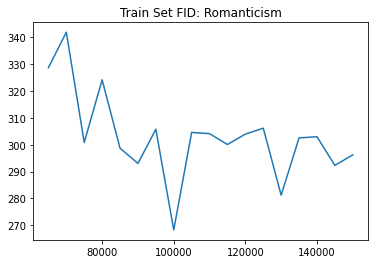

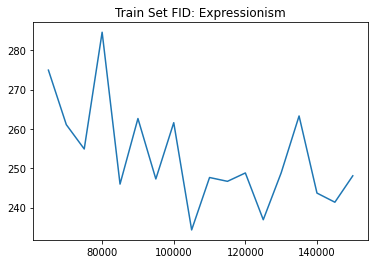

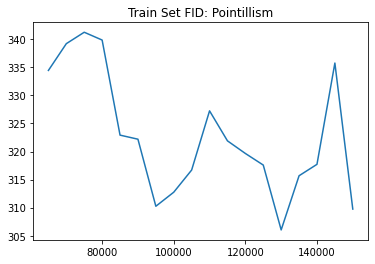

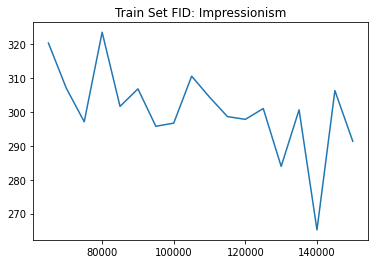

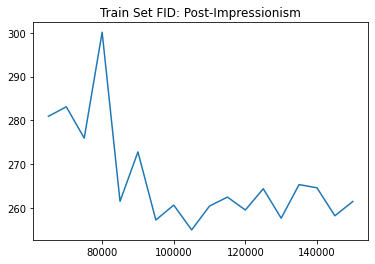

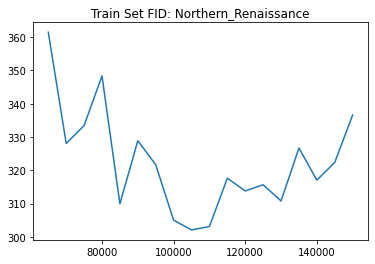

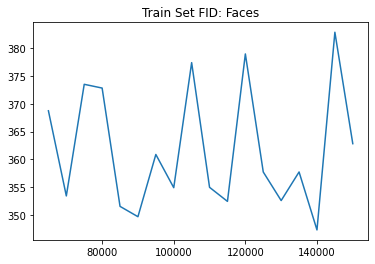

In [ ]:
from matplotlib import pyplot as plt

for i in FIDS.keys():
  plt.figure()
  plt.title("Train Set FID: " + i)
  plt.plot(np.arange(65000, 155000, 5000), np.array(FIDS[i]))
  plt.savefig("finaltrain-" + i + ".png")

In [ ]:
print(fidsFromText)

{'Romanticism': [146.8326455468548, 200.46005984867844, 194.150526580433, 210.3994834726819, 186.70606331637333, 179.56053880978806, 207.8932444901676, 204.48705593095576, 164.34104317701326, 152.9729986534581], 'Expressionism': [179.94152913060105, 182.57183437751394, 176.63047453300442, 164.65970335627708, 145.17948657592046, 128.43929210453285, 135.35597850817396, 145.52286755146235, 127.68284601314122, 118.60196132310386], 'Pointillism': [291.47886112337255, 322.2239422992209, 330.51217953601065, 319.44032546141955, 324.2189862368814, 306.98805341651575, 313.4095467707033, 310.03717696529736, 291.3705715110403, 281.99642752889065], 'Impressionism': [153.2348824341696, 206.90325409069095, 191.12817419490142, 187.3260445688914, 178.14181961938186, 184.9685997378234, 161.6369957619571, 175.0349377003647, 172.9200384828024, 142.49591419445215], 'Post-Impressionism': [196.43950697871605, 216.1824961989438, 188.7427432085909, 201.4704689252304, 176.02269767163966, 167.05300447869115, 164

In [ ]:

srcLabels =[[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
[0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]]

In [ ]:
classList = []
for i in srcLabels:
  classList.append()

Romanticism
Romanticism
Impressionism
Northern_Renaissance
Northern_Renaissance
Post-Impressionism
Romanticism
Post-Impressionism
Expressionism
Expressionism
Expressionism
Romanticism
Post-Impressionism
Impressionism
Romanticism
Expressionism
Northern_Renaissance
Romanticism
Expressionism
Expressionism
Post-Impressionism
Romanticism
Romanticism
Romanticism
Romanticism
Expressionism
Expressionism
Impressionism
Romanticism
Impressionism
Post-Impressionism
Romanticism
Impressionism
Impressionism
Faces
Romanticism
Post-Impressionism
Expressionism
Impressionism
Post-Impressionism
Expressionism
Post-Impressionism
Faces
Romanticism
Expressionism
Expressionism
Romanticism
Expressionism


In [ ]:
import sys

classes = ["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]
FIDS = {}

for i in range(70000, 110000, 10000):
  for j in range(1,8):
    for k in range(7):
      if k != 2:
        if i == 70000:
          print(k)
          if j-1 != k:
            print(classes[k] + "to" + classes[j-1])
            FIDS[classes[k] + "to" + classes[j-1]] = []
        if j-1 != k:
          genArt = "stargan/samples/" + str(i) +"-images/" + str(j) + "/from-" + str(k)
          srcArt = "/content/FID/" + classes[j-1]
          print(genArt)
          print(srcArt)
          FIDS[classes[k] + "to" + classes[j-1]].append(fidmain(genArt,srcArt))

0
1
ExpressionismtoRomanticism
stargan/samples/70000-images/1/from-1
/content/FID/Romanticism
['stargan/samples/70000-images/1/from-1', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.92it/s]


FID:  387.64912641669
3
ImpressionismtoRomanticism
stargan/samples/70000-images/1/from-3
/content/FID/Romanticism
['stargan/samples/70000-images/1/from-3', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.96it/s]


FID:  467.6299745098095
4
Post-ImpressionismtoRomanticism
stargan/samples/70000-images/1/from-4
/content/FID/Romanticism
['stargan/samples/70000-images/1/from-4', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.89it/s]


FID:  451.48082830177725
5
Northern_RenaissancetoRomanticism
stargan/samples/70000-images/1/from-5
/content/FID/Romanticism
['stargan/samples/70000-images/1/from-5', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.82it/s]


FID:  481.7650184884432
6
FacestoRomanticism
stargan/samples/70000-images/1/from-6
/content/FID/Romanticism
['stargan/samples/70000-images/1/from-6', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.22it/s]


FID:  622.3109559612702
0
RomanticismtoExpressionism
stargan/samples/70000-images/2/from-0
/content/FID/Expressionism
['stargan/samples/70000-images/2/from-0', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.06it/s]


FID:  316.0389807068946
1
3
ImpressionismtoExpressionism
stargan/samples/70000-images/2/from-3
/content/FID/Expressionism
['stargan/samples/70000-images/2/from-3', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.16it/s]


FID:  407.61597347587247
4
Post-ImpressionismtoExpressionism
stargan/samples/70000-images/2/from-4
/content/FID/Expressionism
['stargan/samples/70000-images/2/from-4', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.88it/s]


FID:  353.9811101717972
5
Northern_RenaissancetoExpressionism
stargan/samples/70000-images/2/from-5
/content/FID/Expressionism
['stargan/samples/70000-images/2/from-5', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.02it/s]


FID:  487.9450775722996
6
FacestoExpressionism
stargan/samples/70000-images/2/from-6
/content/FID/Expressionism
['stargan/samples/70000-images/2/from-6', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.93it/s]


FID:  514.3790856297964
0
RomanticismtoPointillism
stargan/samples/70000-images/3/from-0
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-0', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


FID:  396.77107969794434
1
ExpressionismtoPointillism
stargan/samples/70000-images/3/from-1
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-1', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


FID:  396.07998564915937
3
ImpressionismtoPointillism
stargan/samples/70000-images/3/from-3
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-3', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


FID:  400.1745373988864
4
Post-ImpressionismtoPointillism
stargan/samples/70000-images/3/from-4
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-4', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


FID:  386.84452011888834
5
Northern_RenaissancetoPointillism
stargan/samples/70000-images/3/from-5
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-5', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


FID:  441.6876583682065
6
FacestoPointillism
stargan/samples/70000-images/3/from-6
/content/FID/Pointillism
['stargan/samples/70000-images/3/from-6', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


FID:  455.765436724662
0
RomanticismtoImpressionism
stargan/samples/70000-images/4/from-0
/content/FID/Impressionism
['stargan/samples/70000-images/4/from-0', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.27it/s]


FID:  385.3920971251747
1
ExpressionismtoImpressionism
stargan/samples/70000-images/4/from-1
/content/FID/Impressionism
['stargan/samples/70000-images/4/from-1', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.11it/s]


FID:  373.78197506443246
3
4
Post-ImpressionismtoImpressionism
stargan/samples/70000-images/4/from-4
/content/FID/Impressionism
['stargan/samples/70000-images/4/from-4', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.34it/s]


FID:  409.7756741574932
5
Northern_RenaissancetoImpressionism
stargan/samples/70000-images/4/from-5
/content/FID/Impressionism
['stargan/samples/70000-images/4/from-5', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.54it/s]


FID:  544.9725468453553
6
FacestoImpressionism
stargan/samples/70000-images/4/from-6
/content/FID/Impressionism
['stargan/samples/70000-images/4/from-6', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.48it/s]


FID:  513.1590678258925
0
RomanticismtoPost-Impressionism
stargan/samples/70000-images/5/from-0
/content/FID/Post-Impressionism
['stargan/samples/70000-images/5/from-0', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


FID:  361.4640144238572
1
ExpressionismtoPost-Impressionism
stargan/samples/70000-images/5/from-1
/content/FID/Post-Impressionism
['stargan/samples/70000-images/5/from-1', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


FID:  343.05458473555217
3
ImpressionismtoPost-Impressionism
stargan/samples/70000-images/5/from-3
/content/FID/Post-Impressionism
['stargan/samples/70000-images/5/from-3', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


FID:  397.72892494855006
4
5
Northern_RenaissancetoPost-Impressionism
stargan/samples/70000-images/5/from-5
/content/FID/Post-Impressionism
['stargan/samples/70000-images/5/from-5', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


FID:  455.06620434738164
6
FacestoPost-Impressionism
stargan/samples/70000-images/5/from-6
/content/FID/Post-Impressionism
['stargan/samples/70000-images/5/from-6', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


FID:  413.7086703606589
0
RomanticismtoNorthern_Renaissance
stargan/samples/70000-images/6/from-0
/content/FID/Northern_Renaissance
['stargan/samples/70000-images/6/from-0', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


FID:  406.02758204657823
1
ExpressionismtoNorthern_Renaissance
stargan/samples/70000-images/6/from-1
/content/FID/Northern_Renaissance
['stargan/samples/70000-images/6/from-1', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


FID:  390.80001448660823
3
ImpressionismtoNorthern_Renaissance
stargan/samples/70000-images/6/from-3
/content/FID/Northern_Renaissance
['stargan/samples/70000-images/6/from-3', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


FID:  385.7022488390112
4
Post-ImpressionismtoNorthern_Renaissance
stargan/samples/70000-images/6/from-4
/content/FID/Northern_Renaissance
['stargan/samples/70000-images/6/from-4', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


FID:  405.1679861179364
5
6
FacestoNorthern_Renaissance
stargan/samples/70000-images/6/from-6
/content/FID/Northern_Renaissance
['stargan/samples/70000-images/6/from-6', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


FID:  438.6160086958174
0
RomanticismtoFaces
stargan/samples/70000-images/7/from-0
/content/FID/Faces
['stargan/samples/70000-images/7/from-0', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


FID:  421.0870751861572
1
ExpressionismtoFaces
stargan/samples/70000-images/7/from-1
/content/FID/Faces
['stargan/samples/70000-images/7/from-1', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.76it/s]


FID:  403.8284251516966
3
ImpressionismtoFaces
stargan/samples/70000-images/7/from-3
/content/FID/Faces
['stargan/samples/70000-images/7/from-3', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.64it/s]


FID:  433.95823736307267
4
Post-ImpressionismtoFaces
stargan/samples/70000-images/7/from-4
/content/FID/Faces
['stargan/samples/70000-images/7/from-4', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


FID:  434.4545499434982
5
Northern_RenaissancetoFaces
stargan/samples/70000-images/7/from-5
/content/FID/Faces
['stargan/samples/70000-images/7/from-5', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.57it/s]


FID:  510.70758847204115
6
stargan/samples/80000-images/1/from-1
/content/FID/Romanticism
['stargan/samples/80000-images/1/from-1', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.62it/s]


FID:  405.5863948207875
stargan/samples/80000-images/1/from-3
/content/FID/Romanticism
['stargan/samples/80000-images/1/from-3', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.67it/s]


FID:  415.5674537717403
stargan/samples/80000-images/1/from-4
/content/FID/Romanticism
['stargan/samples/80000-images/1/from-4', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.90it/s]


FID:  442.54124230028003
stargan/samples/80000-images/1/from-5
/content/FID/Romanticism
['stargan/samples/80000-images/1/from-5', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.81it/s]


FID:  438.52756744375677
stargan/samples/80000-images/1/from-6
/content/FID/Romanticism
['stargan/samples/80000-images/1/from-6', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.82it/s]


FID:  496.75187394310177
stargan/samples/80000-images/2/from-0
/content/FID/Expressionism
['stargan/samples/80000-images/2/from-0', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.79it/s]


FID:  369.57178085130727
stargan/samples/80000-images/2/from-3
/content/FID/Expressionism
['stargan/samples/80000-images/2/from-3', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.74it/s]


FID:  409.5651232629434
stargan/samples/80000-images/2/from-4
/content/FID/Expressionism
['stargan/samples/80000-images/2/from-4', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.99it/s]


FID:  375.5894205413147
stargan/samples/80000-images/2/from-5
/content/FID/Expressionism
['stargan/samples/80000-images/2/from-5', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.75it/s]


FID:  454.5683059260123
stargan/samples/80000-images/2/from-6
/content/FID/Expressionism
['stargan/samples/80000-images/2/from-6', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.62it/s]


FID:  486.5019826290984
stargan/samples/80000-images/3/from-0
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-0', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


FID:  396.0148621401984
stargan/samples/80000-images/3/from-1
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-1', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


FID:  386.66842258179236
stargan/samples/80000-images/3/from-3
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-3', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


FID:  431.27513772763905
stargan/samples/80000-images/3/from-4
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-4', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


FID:  397.7186142439355
stargan/samples/80000-images/3/from-5
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-5', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


FID:  432.9392682812577
stargan/samples/80000-images/3/from-6
/content/FID/Pointillism
['stargan/samples/80000-images/3/from-6', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


FID:  491.93328432057945
stargan/samples/80000-images/4/from-0
/content/FID/Impressionism
['stargan/samples/80000-images/4/from-0', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


FID:  417.72748690752826
stargan/samples/80000-images/4/from-1
/content/FID/Impressionism
['stargan/samples/80000-images/4/from-1', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.66it/s]


FID:  393.95585249886415
stargan/samples/80000-images/4/from-4
/content/FID/Impressionism
['stargan/samples/80000-images/4/from-4', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  7.67it/s]


FID:  386.63292917780785
stargan/samples/80000-images/4/from-5
/content/FID/Impressionism
['stargan/samples/80000-images/4/from-5', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.62it/s]


FID:  495.3334718212758
stargan/samples/80000-images/4/from-6
/content/FID/Impressionism
['stargan/samples/80000-images/4/from-6', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  5.96it/s]


FID:  486.56333331403994
stargan/samples/80000-images/5/from-0
/content/FID/Post-Impressionism
['stargan/samples/80000-images/5/from-0', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.34it/s]


FID:  365.99918982224307
stargan/samples/80000-images/5/from-1
/content/FID/Post-Impressionism
['stargan/samples/80000-images/5/from-1', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.41it/s]


FID:  343.31416230166985
stargan/samples/80000-images/5/from-3
/content/FID/Post-Impressionism
['stargan/samples/80000-images/5/from-3', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.56it/s]


FID:  435.58084327996266
stargan/samples/80000-images/5/from-5
/content/FID/Post-Impressionism
['stargan/samples/80000-images/5/from-5', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


FID:  473.27988962920045
stargan/samples/80000-images/5/from-6
/content/FID/Post-Impressionism
['stargan/samples/80000-images/5/from-6', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


FID:  451.8718413547131
stargan/samples/80000-images/6/from-0
/content/FID/Northern_Renaissance
['stargan/samples/80000-images/6/from-0', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


FID:  425.55877264514686
stargan/samples/80000-images/6/from-1
/content/FID/Northern_Renaissance
['stargan/samples/80000-images/6/from-1', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


FID:  383.4304350649236
stargan/samples/80000-images/6/from-3
/content/FID/Northern_Renaissance
['stargan/samples/80000-images/6/from-3', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


FID:  421.6578139320438
stargan/samples/80000-images/6/from-4
/content/FID/Northern_Renaissance
['stargan/samples/80000-images/6/from-4', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


FID:  456.5800850121552
stargan/samples/80000-images/6/from-6
/content/FID/Northern_Renaissance
['stargan/samples/80000-images/6/from-6', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


FID:  464.84019367511195
stargan/samples/80000-images/7/from-0
/content/FID/Faces
['stargan/samples/80000-images/7/from-0', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.85it/s]


FID:  450.3346228098331
stargan/samples/80000-images/7/from-1
/content/FID/Faces
['stargan/samples/80000-images/7/from-1', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.99it/s]


FID:  403.3022335852371
stargan/samples/80000-images/7/from-3
/content/FID/Faces
['stargan/samples/80000-images/7/from-3', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00,  8.15it/s]


FID:  490.086389179925
stargan/samples/80000-images/7/from-4
/content/FID/Faces
['stargan/samples/80000-images/7/from-4', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00,  8.05it/s]


FID:  472.8905975655153
stargan/samples/80000-images/7/from-5
/content/FID/Faces
['stargan/samples/80000-images/7/from-5', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00,  8.11it/s]


FID:  510.68738581095056
stargan/samples/90000-images/1/from-1
/content/FID/Romanticism
['stargan/samples/90000-images/1/from-1', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.24it/s]


FID:  366.5966365858503
stargan/samples/90000-images/1/from-3
/content/FID/Romanticism
['stargan/samples/90000-images/1/from-3', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.24it/s]


FID:  406.04667624363253
stargan/samples/90000-images/1/from-4
/content/FID/Romanticism
['stargan/samples/90000-images/1/from-4', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.34it/s]


FID:  398.77805025138156
stargan/samples/90000-images/1/from-5
/content/FID/Romanticism
['stargan/samples/90000-images/1/from-5', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.37it/s]


FID:  462.82615298557664
stargan/samples/90000-images/1/from-6
/content/FID/Romanticism
['stargan/samples/90000-images/1/from-6', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.17it/s]


FID:  515.2527850512232
stargan/samples/90000-images/2/from-0
/content/FID/Expressionism
['stargan/samples/90000-images/2/from-0', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.33it/s]


FID:  322.29655120559823
stargan/samples/90000-images/2/from-3
/content/FID/Expressionism
['stargan/samples/90000-images/2/from-3', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.25it/s]


FID:  400.1770581582499
stargan/samples/90000-images/2/from-4
/content/FID/Expressionism
['stargan/samples/90000-images/2/from-4', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.28it/s]


FID:  358.47566666242335
stargan/samples/90000-images/2/from-5
/content/FID/Expressionism
['stargan/samples/90000-images/2/from-5', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


FID:  461.21160763649107
stargan/samples/90000-images/2/from-6
/content/FID/Expressionism
['stargan/samples/90000-images/2/from-6', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  8.21it/s]


FID:  500.6603856066306
stargan/samples/90000-images/3/from-0
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-0', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


FID:  370.4878234122564
stargan/samples/90000-images/3/from-1
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-1', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


FID:  378.44567705035087
stargan/samples/90000-images/3/from-3
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-3', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


FID:  406.37986370863536
stargan/samples/90000-images/3/from-4
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-4', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


FID:  373.25918323189967
stargan/samples/90000-images/3/from-5
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-5', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


FID:  466.24301068488955
stargan/samples/90000-images/3/from-6
/content/FID/Pointillism
['stargan/samples/90000-images/3/from-6', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


FID:  505.7342697346782
stargan/samples/90000-images/4/from-0
/content/FID/Impressionism
['stargan/samples/90000-images/4/from-0', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  7.92it/s]


FID:  400.0473486434363
stargan/samples/90000-images/4/from-1
/content/FID/Impressionism
['stargan/samples/90000-images/4/from-1', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.60it/s]


FID:  377.03621731091323
stargan/samples/90000-images/4/from-4
/content/FID/Impressionism
['stargan/samples/90000-images/4/from-4', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  7.95it/s]


FID:  389.63719837285527
stargan/samples/90000-images/4/from-5
/content/FID/Impressionism
['stargan/samples/90000-images/4/from-5', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.63it/s]


FID:  481.2775685316932
stargan/samples/90000-images/4/from-6
/content/FID/Impressionism
['stargan/samples/90000-images/4/from-6', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


FID:  586.1417203063073
stargan/samples/90000-images/5/from-0
/content/FID/Post-Impressionism
['stargan/samples/90000-images/5/from-0', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.42it/s]


FID:  342.6059468645033
stargan/samples/90000-images/5/from-1
/content/FID/Post-Impressionism
['stargan/samples/90000-images/5/from-1', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.41it/s]


FID:  338.3671136001944
stargan/samples/90000-images/5/from-3
/content/FID/Post-Impressionism
['stargan/samples/90000-images/5/from-3', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.27it/s]


FID:  367.3634206012713
stargan/samples/90000-images/5/from-5
/content/FID/Post-Impressionism
['stargan/samples/90000-images/5/from-5', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.45it/s]


FID:  474.047993923567
stargan/samples/90000-images/5/from-6
/content/FID/Post-Impressionism
['stargan/samples/90000-images/5/from-6', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.64it/s]


FID:  418.11442004406223
stargan/samples/90000-images/6/from-0
/content/FID/Northern_Renaissance
['stargan/samples/90000-images/6/from-0', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


FID:  381.3659689579953
stargan/samples/90000-images/6/from-1
/content/FID/Northern_Renaissance
['stargan/samples/90000-images/6/from-1', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


FID:  386.3331862781898
stargan/samples/90000-images/6/from-3
/content/FID/Northern_Renaissance
['stargan/samples/90000-images/6/from-3', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


FID:  431.022094319233
stargan/samples/90000-images/6/from-4
/content/FID/Northern_Renaissance
['stargan/samples/90000-images/6/from-4', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


FID:  434.97584591886033
stargan/samples/90000-images/6/from-6
/content/FID/Northern_Renaissance
['stargan/samples/90000-images/6/from-6', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


FID:  479.73917585605193
stargan/samples/90000-images/7/from-0
/content/FID/Faces
['stargan/samples/90000-images/7/from-0', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.52it/s]


FID:  434.7650857032818
stargan/samples/90000-images/7/from-1
/content/FID/Faces
['stargan/samples/90000-images/7/from-1', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


FID:  378.86938114409816
stargan/samples/90000-images/7/from-3
/content/FID/Faces
['stargan/samples/90000-images/7/from-3', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.81it/s]


FID:  445.0159231331112
stargan/samples/90000-images/7/from-4
/content/FID/Faces
['stargan/samples/90000-images/7/from-4', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00,  8.01it/s]


FID:  435.9641255164719
stargan/samples/90000-images/7/from-5
/content/FID/Faces
['stargan/samples/90000-images/7/from-5', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00,  8.16it/s]


FID:  500.3698504853516
stargan/samples/100000-images/1/from-1
/content/FID/Romanticism
['stargan/samples/100000-images/1/from-1', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


FID:  336.32390780389716
stargan/samples/100000-images/1/from-3
/content/FID/Romanticism
['stargan/samples/100000-images/1/from-3', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.03it/s]


FID:  428.61850125410604
stargan/samples/100000-images/1/from-4
/content/FID/Romanticism
['stargan/samples/100000-images/1/from-4', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


FID:  384.1370061938681
stargan/samples/100000-images/1/from-5
/content/FID/Romanticism
['stargan/samples/100000-images/1/from-5', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  7.98it/s]


FID:  418.9453011036209
stargan/samples/100000-images/1/from-6
/content/FID/Romanticism
['stargan/samples/100000-images/1/from-6', '/content/FID/Romanticism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:03<00:00,  8.05it/s]


FID:  466.831357872626
stargan/samples/100000-images/2/from-0
/content/FID/Expressionism
['stargan/samples/100000-images/2/from-0', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.85it/s]


FID:  339.75067573262606
stargan/samples/100000-images/2/from-3
/content/FID/Expressionism
['stargan/samples/100000-images/2/from-3', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.77it/s]


FID:  410.00187338074977
stargan/samples/100000-images/2/from-4
/content/FID/Expressionism
['stargan/samples/100000-images/2/from-4', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.97it/s]


FID:  344.11154293633103
stargan/samples/100000-images/2/from-5
/content/FID/Expressionism
['stargan/samples/100000-images/2/from-5', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:03<00:00,  7.77it/s]


FID:  419.861931427214
stargan/samples/100000-images/2/from-6
/content/FID/Expressionism
['stargan/samples/100000-images/2/from-6', '/content/FID/Expressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.68it/s]


FID:  422.4096172215152
stargan/samples/100000-images/3/from-0
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-0', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


FID:  379.0524796103459
stargan/samples/100000-images/3/from-1
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-1', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


FID:  364.6972224772615
stargan/samples/100000-images/3/from-3
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-3', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


FID:  381.7378006673188
stargan/samples/100000-images/3/from-4
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-4', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


FID:  368.47910546284595
stargan/samples/100000-images/3/from-5
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-5', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


FID:  445.3267399611783
stargan/samples/100000-images/3/from-6
/content/FID/Pointillism
['stargan/samples/100000-images/3/from-6', '/content/FID/Pointillism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


FID:  446.4802256459377
stargan/samples/100000-images/4/from-0
/content/FID/Impressionism
['stargan/samples/100000-images/4/from-0', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  7.95it/s]


FID:  392.97308177790245
stargan/samples/100000-images/4/from-1
/content/FID/Impressionism
['stargan/samples/100000-images/4/from-1', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


FID:  359.81856740923445
stargan/samples/100000-images/4/from-4
/content/FID/Impressionism
['stargan/samples/100000-images/4/from-4', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


FID:  392.3975943946888
stargan/samples/100000-images/4/from-5
/content/FID/Impressionism
['stargan/samples/100000-images/4/from-5', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  8.05it/s]


FID:  487.1066780983228
stargan/samples/100000-images/4/from-6
/content/FID/Impressionism
['stargan/samples/100000-images/4/from-6', '/content/FID/Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


FID:  498.652725559047
stargan/samples/100000-images/5/from-0
/content/FID/Post-Impressionism
['stargan/samples/100000-images/5/from-0', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.55it/s]


FID:  332.2507826890364
stargan/samples/100000-images/5/from-1
/content/FID/Post-Impressionism
['stargan/samples/100000-images/5/from-1', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.45it/s]


FID:  320.3760048764427
stargan/samples/100000-images/5/from-3
/content/FID/Post-Impressionism
['stargan/samples/100000-images/5/from-3', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.67it/s]


FID:  363.14703245990415
stargan/samples/100000-images/5/from-5
/content/FID/Post-Impressionism
['stargan/samples/100000-images/5/from-5', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.43it/s]


FID:  454.737006890211
stargan/samples/100000-images/5/from-6
/content/FID/Post-Impressionism
['stargan/samples/100000-images/5/from-6', '/content/FID/Post-Impressionism']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  7.49it/s]


FID:  367.901763345034
stargan/samples/100000-images/6/from-0
/content/FID/Northern_Renaissance
['stargan/samples/100000-images/6/from-0', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


FID:  358.6031814360527
stargan/samples/100000-images/6/from-1
/content/FID/Northern_Renaissance
['stargan/samples/100000-images/6/from-1', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


FID:  365.66922820121226
stargan/samples/100000-images/6/from-3
/content/FID/Northern_Renaissance
['stargan/samples/100000-images/6/from-3', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


FID:  372.15825972470606
stargan/samples/100000-images/6/from-4
/content/FID/Northern_Renaissance
['stargan/samples/100000-images/6/from-4', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


FID:  380.3161228556986
stargan/samples/100000-images/6/from-6
/content/FID/Northern_Renaissance
['stargan/samples/100000-images/6/from-6', '/content/FID/Northern_Renaissance']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


FID:  467.08076855280916
stargan/samples/100000-images/7/from-0
/content/FID/Faces
['stargan/samples/100000-images/7/from-0', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.93it/s]


FID:  418.7766961592908
stargan/samples/100000-images/7/from-1
/content/FID/Faces
['stargan/samples/100000-images/7/from-1', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.81it/s]


FID:  408.0589774882985
stargan/samples/100000-images/7/from-3
/content/FID/Faces
['stargan/samples/100000-images/7/from-3', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


FID:  462.7236849086767
stargan/samples/100000-images/7/from-4
/content/FID/Faces
['stargan/samples/100000-images/7/from-4', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.88it/s]


FID:  459.6424113436948
stargan/samples/100000-images/7/from-5
/content/FID/Faces
['stargan/samples/100000-images/7/from-5', '/content/FID/Faces']


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.86it/s]


FID:  473.72134239516595


In [ ]:
outputFidsMatrix = open("70k-100kFidsByGenreTransfer.txt", 'a')
print(FIDS)
for x in FIDS.keys():
  # print(x)
  outputFidsMatrix.write(x)
  outputFidsMatrix.write("\n")
  for y in FIDS[x]:
    outputFidsMatrix.write(str(y))
    outputFidsMatrix.write("\n")

outputFidsMatrix.close()

{'ExpressionismtoRomanticism': [387.64912641669, 405.5863948207875, 366.5966365858503, 336.32390780389716], 'ImpressionismtoRomanticism': [467.6299745098095, 415.5674537717403, 406.04667624363253, 428.61850125410604], 'Post-ImpressionismtoRomanticism': [451.48082830177725, 442.54124230028003, 398.77805025138156, 384.1370061938681], 'Northern_RenaissancetoRomanticism': [481.7650184884432, 438.52756744375677, 462.82615298557664, 418.9453011036209], 'FacestoRomanticism': [622.3109559612702, 496.75187394310177, 515.2527850512232, 466.831357872626], 'RomanticismtoExpressionism': [316.0389807068946, 369.57178085130727, 322.29655120559823, 339.75067573262606], 'ImpressionismtoExpressionism': [407.61597347587247, 409.5651232629434, 400.1770581582499, 410.00187338074977], 'Post-ImpressionismtoExpressionism': [353.9811101717972, 375.5894205413147, 358.47566666242335, 344.11154293633103], 'Northern_RenaissancetoExpressionism': [487.9450775722996, 454.5683059260123, 461.21160763649107, 419.8619314